# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

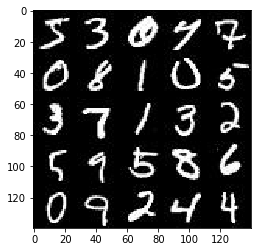

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

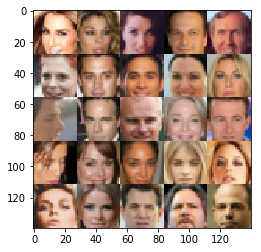

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    with tf.name_scope("input"):
        input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="image")
        input_noise = tf.placeholder(tf.float32, [None, z_dim], name="noise")
        rate_learn = tf.placeholder(tf.float32, name="learn_rate")

    return input_image, input_noise, rate_learn


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        conv_0 = tf.layers.conv2d(images, 64, 5, strides=2, activation=tf.nn.relu, padding="same")
        conv_1 = tf.layers.conv2d(conv_0, 128, 5, strides=2, activation=tf.nn.relu, padding="same")
        conv_2 = tf.layers.conv2d(conv_1, 256, 5, strides=2, activation=tf.nn.relu, padding="same")
        c2shp = conv_2.get_shape().as_list()
        flat_0 = tf.reshape(conv_2, [-1, c2shp[1]*c2shp[2]*c2shp[3]])
        logit = tf.layers.dense(flat_0, 1)
        sigmd = tf.sigmoid(logit)
    return sigmd, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    rate_leak = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        proj = tf.layers.dense(z, 7*7*128, activation=None)
        ucon_0 = tf.reshape(proj, [-1,7,7,128])
        ucon_0 = tf.layers.batch_normalization(ucon_0, training=is_train)
        ucon_0 = tf.maximum(rate_leak*ucon_0, ucon_0)
        ucon_1 = tf.layers.conv2d_transpose(ucon_0, 32, 5, strides=2, padding="same", activation=None)
        ucon_1 = tf.layers.batch_normalization(ucon_1, training=is_train)
        ucon_1 = tf.maximum(rate_leak*ucon_1, ucon_1)
        logit = tf.layers.conv2d_transpose(ucon_1, out_channel_dim, 5, strides=2, padding="same", activation=None)
        image = tf.tanh(logit)
    return image


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    model_genr = generator(input_z, out_channel_dim)
    model_disc_real, logit_disc_real = discriminator(input_real)
    model_disc_fake, logit_disc_fake = discriminator(model_genr, reuse=True)
    label_real = tf.ones_like(model_disc_fake)
    label_fake = tf.zeros_like(model_disc_fake)
    loss_disc_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_real, labels=label_real))
    loss_disc_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_fake, labels=label_fake))
    loss_disc = loss_disc_real + loss_disc_fake
    loss_genr = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_disc_fake, labels=label_real))
    return loss_disc, loss_genr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars_all = tf.trainable_variables()
    vars_disc = [v for v in vars_all if v.name.startswith("discriminator")]
    vars_genr = [v for v in vars_all if v.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        trainer_disc = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=vars_disc)
        trainer_genr = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=vars_genr)
    return trainer_disc, trainer_genr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    msg_string = "Epoch {:>3}/{:<3} Batch {:>3} | Loss: Discriminator = {:>3.5f}, Generator = {:>3.5f}"
    input_real, input_z, rate_learn = model_inputs(*data_shape[1:], z_dim)
    loss_disc, loss_genr = model_loss(input_real, input_z, data_shape[-1])
    trainer_disc, trainer_genr = model_opt(loss_disc, loss_genr, rate_learn, beta1)
    batch = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1
                batch_noise = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                batch_images *= 2.0
                sess.run(trainer_disc, feed_dict={input_real: batch_images, input_z: batch_noise, rate_learn: learning_rate})
                sess.run(trainer_genr, feed_dict={input_z: batch_noise, rate_learn: learning_rate})
                if batch % 10 == 0:
                    lossval_disc, lossval_genr = sess.run([loss_disc, loss_genr],
                                                          feed_dict={input_real: batch_images, input_z: batch_noise})
                    print(msg_string.format(epoch_i+1, epoch_count, batch, lossval_disc, lossval_genr))
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[-1], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch   1/2   Batch  10 | Loss: Discriminator = 0.65686, Generator = 1.37485
Epoch   1/2   Batch  20 | Loss: Discriminator = 1.12944, Generator = 0.40208
Epoch   1/2   Batch  30 | Loss: Discriminator = 0.66823, Generator = 1.00486
Epoch   1/2   Batch  40 | Loss: Discriminator = 0.76168, Generator = 0.95517
Epoch   1/2   Batch  50 | Loss: Discriminator = 0.84209, Generator = 1.52232
Epoch   1/2   Batch  60 | Loss: Discriminator = 0.70356, Generator = 1.58559
Epoch   1/2   Batch  70 | Loss: Discriminator = 0.71793, Generator = 2.07503
Epoch   1/2   Batch  80 | Loss: Discriminator = 0.55236, Generator = 1.42256
Epoch   1/2   Batch  90 | Loss: Discriminator = 0.67461, Generator = 1.91456
Epoch   1/2   Batch 100 | Loss: Discriminator = 0.71815, Generator = 1.85864


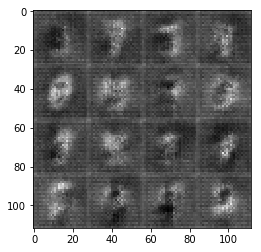

Epoch   1/2   Batch 110 | Loss: Discriminator = 0.74815, Generator = 1.74341
Epoch   1/2   Batch 120 | Loss: Discriminator = 0.82012, Generator = 0.84683
Epoch   1/2   Batch 130 | Loss: Discriminator = 0.76304, Generator = 1.61978
Epoch   1/2   Batch 140 | Loss: Discriminator = 0.77450, Generator = 1.63506
Epoch   1/2   Batch 150 | Loss: Discriminator = 1.22136, Generator = 2.28398
Epoch   1/2   Batch 160 | Loss: Discriminator = 1.61423, Generator = 0.25752
Epoch   1/2   Batch 170 | Loss: Discriminator = 0.79894, Generator = 1.38778
Epoch   1/2   Batch 180 | Loss: Discriminator = 0.82711, Generator = 1.07828
Epoch   1/2   Batch 190 | Loss: Discriminator = 0.97872, Generator = 1.58486
Epoch   1/2   Batch 200 | Loss: Discriminator = 0.86462, Generator = 1.31850


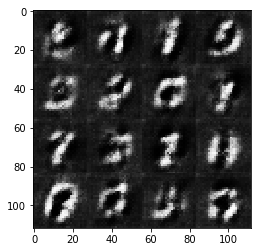

Epoch   1/2   Batch 210 | Loss: Discriminator = 0.84439, Generator = 1.16482
Epoch   1/2   Batch 220 | Loss: Discriminator = 0.96865, Generator = 0.89602
Epoch   1/2   Batch 230 | Loss: Discriminator = 0.93060, Generator = 0.97408
Epoch   1/2   Batch 240 | Loss: Discriminator = 0.97594, Generator = 1.02890
Epoch   1/2   Batch 250 | Loss: Discriminator = 1.06699, Generator = 0.92445
Epoch   1/2   Batch 260 | Loss: Discriminator = 0.97928, Generator = 0.87754
Epoch   1/2   Batch 270 | Loss: Discriminator = 1.01155, Generator = 0.99267
Epoch   1/2   Batch 280 | Loss: Discriminator = 1.00091, Generator = 0.95312
Epoch   1/2   Batch 290 | Loss: Discriminator = 1.07348, Generator = 1.42999
Epoch   1/2   Batch 300 | Loss: Discriminator = 1.05178, Generator = 1.44025


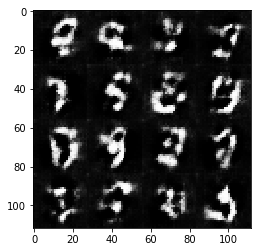

Epoch   1/2   Batch 310 | Loss: Discriminator = 1.02462, Generator = 1.31336
Epoch   1/2   Batch 320 | Loss: Discriminator = 1.07636, Generator = 0.73698
Epoch   1/2   Batch 330 | Loss: Discriminator = 0.98009, Generator = 0.96152
Epoch   1/2   Batch 340 | Loss: Discriminator = 1.02529, Generator = 0.74431
Epoch   1/2   Batch 350 | Loss: Discriminator = 1.07552, Generator = 1.83909
Epoch   1/2   Batch 360 | Loss: Discriminator = 1.42617, Generator = 0.34007
Epoch   1/2   Batch 370 | Loss: Discriminator = 0.97718, Generator = 1.16516
Epoch   1/2   Batch 380 | Loss: Discriminator = 1.04246, Generator = 1.61713
Epoch   1/2   Batch 390 | Loss: Discriminator = 1.09331, Generator = 0.80775
Epoch   1/2   Batch 400 | Loss: Discriminator = 1.04546, Generator = 0.89225


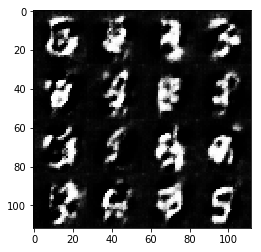

Epoch   1/2   Batch 410 | Loss: Discriminator = 1.05860, Generator = 0.95326
Epoch   1/2   Batch 420 | Loss: Discriminator = 1.01255, Generator = 1.04573
Epoch   1/2   Batch 430 | Loss: Discriminator = 1.10667, Generator = 1.22482
Epoch   1/2   Batch 440 | Loss: Discriminator = 0.95233, Generator = 1.05248
Epoch   1/2   Batch 450 | Loss: Discriminator = 0.91263, Generator = 1.10256
Epoch   1/2   Batch 460 | Loss: Discriminator = 1.00497, Generator = 1.50397
Epoch   1/2   Batch 470 | Loss: Discriminator = 1.02456, Generator = 0.74400
Epoch   1/2   Batch 480 | Loss: Discriminator = 1.03371, Generator = 0.69314
Epoch   1/2   Batch 490 | Loss: Discriminator = 1.13953, Generator = 1.53918
Epoch   1/2   Batch 500 | Loss: Discriminator = 0.97607, Generator = 1.39763


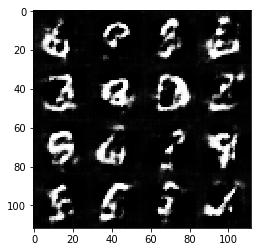

Epoch   1/2   Batch 510 | Loss: Discriminator = 0.96399, Generator = 1.17551
Epoch   1/2   Batch 520 | Loss: Discriminator = 1.02877, Generator = 1.36826
Epoch   1/2   Batch 530 | Loss: Discriminator = 0.91867, Generator = 0.98007
Epoch   1/2   Batch 540 | Loss: Discriminator = 1.06816, Generator = 1.90186
Epoch   1/2   Batch 550 | Loss: Discriminator = 0.91568, Generator = 0.92998
Epoch   1/2   Batch 560 | Loss: Discriminator = 0.97945, Generator = 0.91908
Epoch   1/2   Batch 570 | Loss: Discriminator = 1.02559, Generator = 0.92904
Epoch   1/2   Batch 580 | Loss: Discriminator = 0.98245, Generator = 1.27874
Epoch   1/2   Batch 590 | Loss: Discriminator = 0.91844, Generator = 1.33028
Epoch   1/2   Batch 600 | Loss: Discriminator = 0.86902, Generator = 1.73623


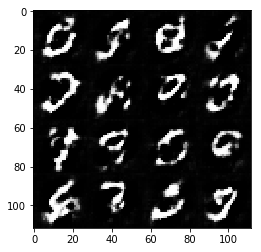

Epoch   1/2   Batch 610 | Loss: Discriminator = 0.94113, Generator = 1.47972
Epoch   1/2   Batch 620 | Loss: Discriminator = 0.85280, Generator = 1.41950
Epoch   1/2   Batch 630 | Loss: Discriminator = 0.92993, Generator = 0.82779
Epoch   1/2   Batch 640 | Loss: Discriminator = 0.87626, Generator = 1.08241
Epoch   1/2   Batch 650 | Loss: Discriminator = 1.08616, Generator = 0.66708
Epoch   1/2   Batch 660 | Loss: Discriminator = 1.13615, Generator = 0.52990
Epoch   1/2   Batch 670 | Loss: Discriminator = 0.93686, Generator = 0.73803
Epoch   1/2   Batch 680 | Loss: Discriminator = 0.99617, Generator = 0.77936
Epoch   1/2   Batch 690 | Loss: Discriminator = 0.86870, Generator = 1.00007
Epoch   1/2   Batch 700 | Loss: Discriminator = 0.86665, Generator = 0.98289


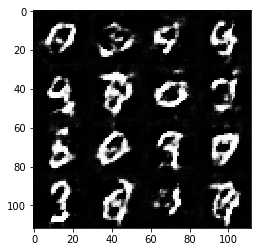

Epoch   1/2   Batch 710 | Loss: Discriminator = 1.00046, Generator = 1.51557
Epoch   1/2   Batch 720 | Loss: Discriminator = 0.80206, Generator = 1.18538
Epoch   1/2   Batch 730 | Loss: Discriminator = 0.95332, Generator = 1.45493
Epoch   1/2   Batch 740 | Loss: Discriminator = 0.78047, Generator = 1.38480
Epoch   1/2   Batch 750 | Loss: Discriminator = 0.91535, Generator = 1.29026
Epoch   1/2   Batch 760 | Loss: Discriminator = 0.83708, Generator = 1.67948
Epoch   1/2   Batch 770 | Loss: Discriminator = 0.96992, Generator = 1.37768
Epoch   1/2   Batch 780 | Loss: Discriminator = 0.99704, Generator = 1.28254
Epoch   1/2   Batch 790 | Loss: Discriminator = 0.92066, Generator = 0.86006
Epoch   1/2   Batch 800 | Loss: Discriminator = 0.89149, Generator = 0.98946


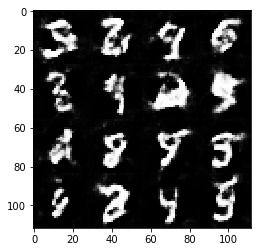

Epoch   1/2   Batch 810 | Loss: Discriminator = 0.96254, Generator = 0.71824
Epoch   1/2   Batch 820 | Loss: Discriminator = 0.92465, Generator = 1.04703
Epoch   1/2   Batch 830 | Loss: Discriminator = 1.09992, Generator = 0.59309
Epoch   1/2   Batch 840 | Loss: Discriminator = 1.05147, Generator = 1.29168
Epoch   1/2   Batch 850 | Loss: Discriminator = 0.97090, Generator = 0.78295
Epoch   1/2   Batch 860 | Loss: Discriminator = 0.99304, Generator = 0.99966
Epoch   1/2   Batch 870 | Loss: Discriminator = 1.16922, Generator = 0.94505
Epoch   1/2   Batch 880 | Loss: Discriminator = 0.91824, Generator = 0.90031
Epoch   1/2   Batch 890 | Loss: Discriminator = 1.01249, Generator = 0.78542
Epoch   1/2   Batch 900 | Loss: Discriminator = 0.88682, Generator = 1.09533


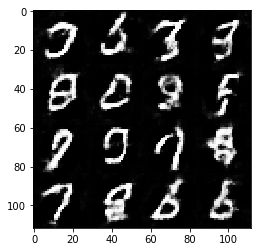

Epoch   1/2   Batch 910 | Loss: Discriminator = 1.05681, Generator = 0.95326
Epoch   1/2   Batch 920 | Loss: Discriminator = 0.90303, Generator = 1.02307
Epoch   1/2   Batch 930 | Loss: Discriminator = 1.09625, Generator = 1.35434
Epoch   2/2   Batch 940 | Loss: Discriminator = 1.37000, Generator = 0.40859
Epoch   2/2   Batch 950 | Loss: Discriminator = 1.07427, Generator = 0.59225
Epoch   2/2   Batch 960 | Loss: Discriminator = 0.97766, Generator = 0.84614
Epoch   2/2   Batch 970 | Loss: Discriminator = 0.98781, Generator = 0.99802
Epoch   2/2   Batch 980 | Loss: Discriminator = 1.04017, Generator = 0.72306
Epoch   2/2   Batch 990 | Loss: Discriminator = 1.37255, Generator = 0.42796
Epoch   2/2   Batch 1000 | Loss: Discriminator = 0.99894, Generator = 0.71622


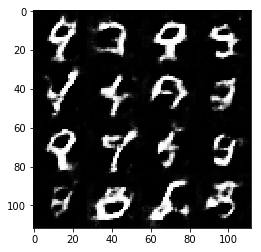

Epoch   2/2   Batch 1010 | Loss: Discriminator = 1.15831, Generator = 0.52493
Epoch   2/2   Batch 1020 | Loss: Discriminator = 0.84691, Generator = 1.37156
Epoch   2/2   Batch 1030 | Loss: Discriminator = 1.04341, Generator = 1.24756
Epoch   2/2   Batch 1040 | Loss: Discriminator = 1.00662, Generator = 1.15448
Epoch   2/2   Batch 1050 | Loss: Discriminator = 0.95768, Generator = 1.41836
Epoch   2/2   Batch 1060 | Loss: Discriminator = 1.00752, Generator = 0.79024
Epoch   2/2   Batch 1070 | Loss: Discriminator = 0.91815, Generator = 1.77966
Epoch   2/2   Batch 1080 | Loss: Discriminator = 1.50919, Generator = 0.32814
Epoch   2/2   Batch 1090 | Loss: Discriminator = 0.99436, Generator = 1.03657
Epoch   2/2   Batch 1100 | Loss: Discriminator = 1.01429, Generator = 0.88274


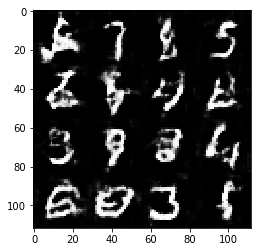

Epoch   2/2   Batch 1110 | Loss: Discriminator = 0.74091, Generator = 1.25455
Epoch   2/2   Batch 1120 | Loss: Discriminator = 0.93575, Generator = 1.00374
Epoch   2/2   Batch 1130 | Loss: Discriminator = 1.04689, Generator = 0.93115
Epoch   2/2   Batch 1140 | Loss: Discriminator = 0.95409, Generator = 0.81714
Epoch   2/2   Batch 1150 | Loss: Discriminator = 1.17501, Generator = 0.60313
Epoch   2/2   Batch 1160 | Loss: Discriminator = 1.17902, Generator = 0.55226
Epoch   2/2   Batch 1170 | Loss: Discriminator = 1.18596, Generator = 0.59073
Epoch   2/2   Batch 1180 | Loss: Discriminator = 1.31890, Generator = 0.47055
Epoch   2/2   Batch 1190 | Loss: Discriminator = 0.89050, Generator = 0.99011
Epoch   2/2   Batch 1200 | Loss: Discriminator = 0.97448, Generator = 0.72137


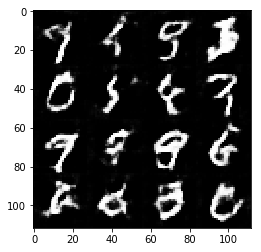

Epoch   2/2   Batch 1210 | Loss: Discriminator = 0.77076, Generator = 1.27739
Epoch   2/2   Batch 1220 | Loss: Discriminator = 0.96107, Generator = 1.39302
Epoch   2/2   Batch 1230 | Loss: Discriminator = 1.01928, Generator = 1.40982
Epoch   2/2   Batch 1240 | Loss: Discriminator = 1.01308, Generator = 0.92081
Epoch   2/2   Batch 1250 | Loss: Discriminator = 0.99359, Generator = 0.90758
Epoch   2/2   Batch 1260 | Loss: Discriminator = 0.98078, Generator = 1.06034
Epoch   2/2   Batch 1270 | Loss: Discriminator = 1.22564, Generator = 0.51774
Epoch   2/2   Batch 1280 | Loss: Discriminator = 0.89388, Generator = 1.04137
Epoch   2/2   Batch 1290 | Loss: Discriminator = 0.94065, Generator = 1.43062
Epoch   2/2   Batch 1300 | Loss: Discriminator = 1.12821, Generator = 1.22406


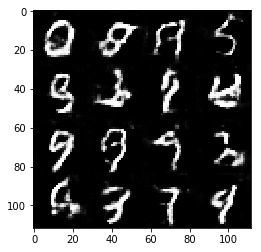

Epoch   2/2   Batch 1310 | Loss: Discriminator = 1.06476, Generator = 0.75811
Epoch   2/2   Batch 1320 | Loss: Discriminator = 1.11475, Generator = 0.85604
Epoch   2/2   Batch 1330 | Loss: Discriminator = 0.90867, Generator = 1.35098
Epoch   2/2   Batch 1340 | Loss: Discriminator = 1.09701, Generator = 1.30518
Epoch   2/2   Batch 1350 | Loss: Discriminator = 1.23802, Generator = 1.35832
Epoch   2/2   Batch 1360 | Loss: Discriminator = 1.08037, Generator = 0.67457
Epoch   2/2   Batch 1370 | Loss: Discriminator = 0.89970, Generator = 1.04829
Epoch   2/2   Batch 1380 | Loss: Discriminator = 1.00557, Generator = 0.82160
Epoch   2/2   Batch 1390 | Loss: Discriminator = 0.86400, Generator = 1.07533
Epoch   2/2   Batch 1400 | Loss: Discriminator = 1.03800, Generator = 1.15829


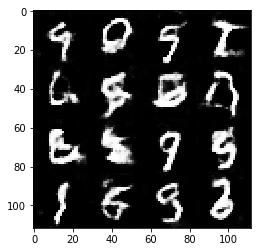

Epoch   2/2   Batch 1410 | Loss: Discriminator = 0.82718, Generator = 1.56100
Epoch   2/2   Batch 1420 | Loss: Discriminator = 0.96130, Generator = 1.20564
Epoch   2/2   Batch 1430 | Loss: Discriminator = 1.00374, Generator = 0.96383
Epoch   2/2   Batch 1440 | Loss: Discriminator = 0.80059, Generator = 1.16720
Epoch   2/2   Batch 1450 | Loss: Discriminator = 0.99489, Generator = 1.30787
Epoch   2/2   Batch 1460 | Loss: Discriminator = 1.02856, Generator = 0.73000
Epoch   2/2   Batch 1470 | Loss: Discriminator = 1.12037, Generator = 0.71431
Epoch   2/2   Batch 1480 | Loss: Discriminator = 0.95849, Generator = 0.75640
Epoch   2/2   Batch 1490 | Loss: Discriminator = 0.91494, Generator = 0.98707
Epoch   2/2   Batch 1500 | Loss: Discriminator = 0.88959, Generator = 0.85950


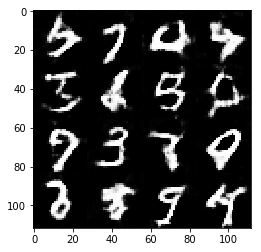

Epoch   2/2   Batch 1510 | Loss: Discriminator = 0.87727, Generator = 1.13145
Epoch   2/2   Batch 1520 | Loss: Discriminator = 0.88691, Generator = 0.93773
Epoch   2/2   Batch 1530 | Loss: Discriminator = 1.04219, Generator = 0.74946
Epoch   2/2   Batch 1540 | Loss: Discriminator = 0.89170, Generator = 0.88065
Epoch   2/2   Batch 1550 | Loss: Discriminator = 0.81488, Generator = 1.12737
Epoch   2/2   Batch 1560 | Loss: Discriminator = 1.02345, Generator = 0.80460
Epoch   2/2   Batch 1570 | Loss: Discriminator = 0.85651, Generator = 1.14277
Epoch   2/2   Batch 1580 | Loss: Discriminator = 0.98265, Generator = 0.85115
Epoch   2/2   Batch 1590 | Loss: Discriminator = 1.08599, Generator = 0.63953
Epoch   2/2   Batch 1600 | Loss: Discriminator = 1.01102, Generator = 1.38229


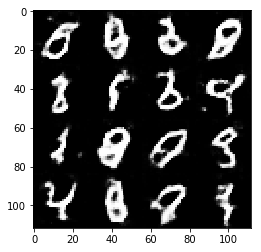

Epoch   2/2   Batch 1610 | Loss: Discriminator = 0.93369, Generator = 1.04518
Epoch   2/2   Batch 1620 | Loss: Discriminator = 0.86464, Generator = 1.10573
Epoch   2/2   Batch 1630 | Loss: Discriminator = 1.00537, Generator = 1.62984
Epoch   2/2   Batch 1640 | Loss: Discriminator = 0.95673, Generator = 0.92848
Epoch   2/2   Batch 1650 | Loss: Discriminator = 1.42553, Generator = 0.34560
Epoch   2/2   Batch 1660 | Loss: Discriminator = 0.93908, Generator = 1.03016
Epoch   2/2   Batch 1670 | Loss: Discriminator = 0.92000, Generator = 1.04937
Epoch   2/2   Batch 1680 | Loss: Discriminator = 0.93563, Generator = 1.48675
Epoch   2/2   Batch 1690 | Loss: Discriminator = 0.80194, Generator = 1.18996
Epoch   2/2   Batch 1700 | Loss: Discriminator = 0.97499, Generator = 0.72899


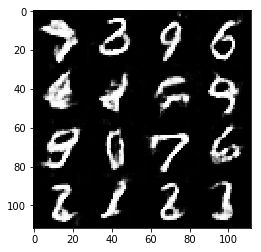

Epoch   2/2   Batch 1710 | Loss: Discriminator = 1.12666, Generator = 0.60652
Epoch   2/2   Batch 1720 | Loss: Discriminator = 0.98637, Generator = 0.98253
Epoch   2/2   Batch 1730 | Loss: Discriminator = 1.05654, Generator = 0.86067
Epoch   2/2   Batch 1740 | Loss: Discriminator = 1.06837, Generator = 0.66578
Epoch   2/2   Batch 1750 | Loss: Discriminator = 0.78749, Generator = 1.27617
Epoch   2/2   Batch 1760 | Loss: Discriminator = 0.92704, Generator = 1.67987
Epoch   2/2   Batch 1770 | Loss: Discriminator = 0.93078, Generator = 1.73932
Epoch   2/2   Batch 1780 | Loss: Discriminator = 1.13701, Generator = 0.58565
Epoch   2/2   Batch 1790 | Loss: Discriminator = 0.90002, Generator = 0.73816
Epoch   2/2   Batch 1800 | Loss: Discriminator = 0.79906, Generator = 1.22862


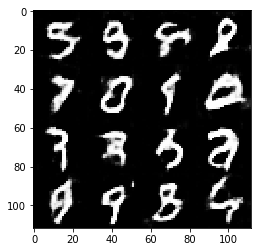

Epoch   2/2   Batch 1810 | Loss: Discriminator = 0.93138, Generator = 1.04430
Epoch   2/2   Batch 1820 | Loss: Discriminator = 1.25405, Generator = 2.26801
Epoch   2/2   Batch 1830 | Loss: Discriminator = 0.91810, Generator = 0.95057
Epoch   2/2   Batch 1840 | Loss: Discriminator = 1.01310, Generator = 0.82833
Epoch   2/2   Batch 1850 | Loss: Discriminator = 1.15456, Generator = 0.55233
Epoch   2/2   Batch 1860 | Loss: Discriminator = 0.95577, Generator = 1.42598
Epoch   2/2   Batch 1870 | Loss: Discriminator = 1.13539, Generator = 0.54418


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch   1/1   Batch  10 | Loss: Discriminator = 0.45515, Generator = 1.07439
Epoch   1/1   Batch  20 | Loss: Discriminator = 0.27533, Generator = 1.57840
Epoch   1/1   Batch  30 | Loss: Discriminator = 0.14235, Generator = 2.60837
Epoch   1/1   Batch  40 | Loss: Discriminator = 0.13202, Generator = 2.60410
Epoch   1/1   Batch  50 | Loss: Discriminator = 0.35140, Generator = 1.45123
Epoch   1/1   Batch  60 | Loss: Discriminator = 1.40341, Generator = 3.59049
Epoch   1/1   Batch  70 | Loss: Discriminator = 1.63770, Generator = 0.26804
Epoch   1/1   Batch  80 | Loss: Discriminator = 0.85800, Generator = 1.16007
Epoch   1/1   Batch  90 | Loss: Discriminator = 0.84321, Generator = 0.99450
Epoch   1/1   Batch 100 | Loss: Discriminator = 0.78956, Generator = 1.09228


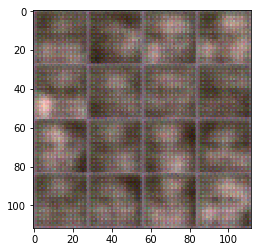

Epoch   1/1   Batch 110 | Loss: Discriminator = 0.89176, Generator = 0.86733
Epoch   1/1   Batch 120 | Loss: Discriminator = 1.18160, Generator = 2.00117
Epoch   1/1   Batch 130 | Loss: Discriminator = 1.28184, Generator = 0.40873
Epoch   1/1   Batch 140 | Loss: Discriminator = 0.89467, Generator = 0.75046
Epoch   1/1   Batch 150 | Loss: Discriminator = 0.85699, Generator = 1.11169
Epoch   1/1   Batch 160 | Loss: Discriminator = 0.98355, Generator = 1.02688
Epoch   1/1   Batch 170 | Loss: Discriminator = 0.97675, Generator = 1.66973
Epoch   1/1   Batch 180 | Loss: Discriminator = 1.09357, Generator = 0.68027
Epoch   1/1   Batch 190 | Loss: Discriminator = 1.01257, Generator = 0.73030
Epoch   1/1   Batch 200 | Loss: Discriminator = 1.05576, Generator = 0.88139


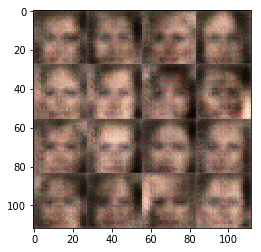

Epoch   1/1   Batch 210 | Loss: Discriminator = 1.20996, Generator = 0.49821
Epoch   1/1   Batch 220 | Loss: Discriminator = 1.23416, Generator = 0.46766
Epoch   1/1   Batch 230 | Loss: Discriminator = 1.05841, Generator = 0.62327
Epoch   1/1   Batch 240 | Loss: Discriminator = 0.87491, Generator = 0.93411
Epoch   1/1   Batch 250 | Loss: Discriminator = 0.98149, Generator = 0.98541
Epoch   1/1   Batch 260 | Loss: Discriminator = 1.08766, Generator = 0.67881
Epoch   1/1   Batch 270 | Loss: Discriminator = 1.15611, Generator = 0.56881
Epoch   1/1   Batch 280 | Loss: Discriminator = 1.60295, Generator = 0.28678
Epoch   1/1   Batch 290 | Loss: Discriminator = 1.37264, Generator = 0.38617
Epoch   1/1   Batch 300 | Loss: Discriminator = 1.09400, Generator = 0.77179


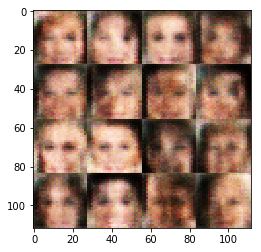

Epoch   1/1   Batch 310 | Loss: Discriminator = 0.91825, Generator = 0.93759
Epoch   1/1   Batch 320 | Loss: Discriminator = 0.99938, Generator = 0.97086
Epoch   1/1   Batch 330 | Loss: Discriminator = 1.19134, Generator = 1.47248
Epoch   1/1   Batch 340 | Loss: Discriminator = 1.22336, Generator = 1.20330
Epoch   1/1   Batch 350 | Loss: Discriminator = 1.39019, Generator = 1.25457
Epoch   1/1   Batch 360 | Loss: Discriminator = 1.11917, Generator = 0.64428
Epoch   1/1   Batch 370 | Loss: Discriminator = 1.13541, Generator = 0.86175
Epoch   1/1   Batch 380 | Loss: Discriminator = 1.54135, Generator = 0.34592
Epoch   1/1   Batch 390 | Loss: Discriminator = 1.11967, Generator = 0.82646
Epoch   1/1   Batch 400 | Loss: Discriminator = 1.35219, Generator = 0.46899


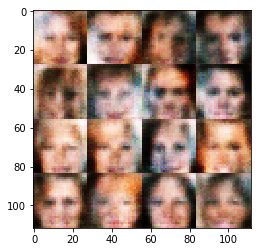

Epoch   1/1   Batch 410 | Loss: Discriminator = 1.22073, Generator = 0.63935
Epoch   1/1   Batch 420 | Loss: Discriminator = 1.24889, Generator = 0.55790
Epoch   1/1   Batch 430 | Loss: Discriminator = 0.98737, Generator = 2.18025
Epoch   1/1   Batch 440 | Loss: Discriminator = 1.20346, Generator = 0.81366
Epoch   1/1   Batch 450 | Loss: Discriminator = 1.09200, Generator = 1.13993
Epoch   1/1   Batch 460 | Loss: Discriminator = 1.18912, Generator = 0.78345
Epoch   1/1   Batch 470 | Loss: Discriminator = 1.21765, Generator = 0.63449
Epoch   1/1   Batch 480 | Loss: Discriminator = 1.15120, Generator = 0.69604
Epoch   1/1   Batch 490 | Loss: Discriminator = 1.23202, Generator = 0.82510
Epoch   1/1   Batch 500 | Loss: Discriminator = 1.58422, Generator = 2.52517


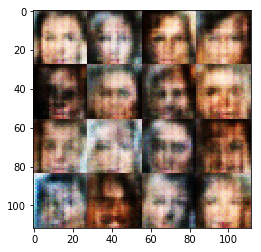

Epoch   1/1   Batch 510 | Loss: Discriminator = 1.17728, Generator = 0.82849
Epoch   1/1   Batch 520 | Loss: Discriminator = 0.81832, Generator = 1.81776
Epoch   1/1   Batch 530 | Loss: Discriminator = 1.18094, Generator = 0.87106
Epoch   1/1   Batch 540 | Loss: Discriminator = 1.18931, Generator = 0.77488
Epoch   1/1   Batch 550 | Loss: Discriminator = 1.40276, Generator = 0.42398
Epoch   1/1   Batch 560 | Loss: Discriminator = 1.06861, Generator = 0.75151
Epoch   1/1   Batch 570 | Loss: Discriminator = 1.10327, Generator = 0.87549
Epoch   1/1   Batch 580 | Loss: Discriminator = 1.14242, Generator = 0.85622
Epoch   1/1   Batch 590 | Loss: Discriminator = 1.19294, Generator = 0.78344
Epoch   1/1   Batch 600 | Loss: Discriminator = 1.10418, Generator = 0.82585


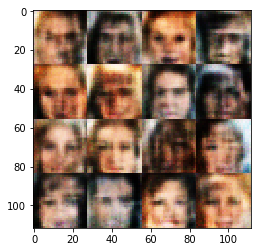

Epoch   1/1   Batch 610 | Loss: Discriminator = 1.20329, Generator = 0.76871
Epoch   1/1   Batch 620 | Loss: Discriminator = 0.96207, Generator = 1.12184
Epoch   1/1   Batch 630 | Loss: Discriminator = 1.20367, Generator = 0.78588
Epoch   1/1   Batch 640 | Loss: Discriminator = 1.05004, Generator = 0.95259
Epoch   1/1   Batch 650 | Loss: Discriminator = 1.18813, Generator = 0.79718
Epoch   1/1   Batch 660 | Loss: Discriminator = 1.04123, Generator = 0.85427
Epoch   1/1   Batch 670 | Loss: Discriminator = 1.18173, Generator = 0.83659
Epoch   1/1   Batch 680 | Loss: Discriminator = 1.12055, Generator = 0.78637
Epoch   1/1   Batch 690 | Loss: Discriminator = 1.28745, Generator = 0.75222
Epoch   1/1   Batch 700 | Loss: Discriminator = 1.16990, Generator = 0.77751


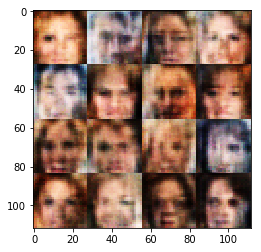

Epoch   1/1   Batch 710 | Loss: Discriminator = 1.20652, Generator = 0.53911
Epoch   1/1   Batch 720 | Loss: Discriminator = 1.14660, Generator = 0.73053
Epoch   1/1   Batch 730 | Loss: Discriminator = 1.08270, Generator = 1.01369
Epoch   1/1   Batch 740 | Loss: Discriminator = 1.12030, Generator = 0.87506
Epoch   1/1   Batch 750 | Loss: Discriminator = 1.10170, Generator = 0.83086
Epoch   1/1   Batch 760 | Loss: Discriminator = 1.18769, Generator = 0.73733
Epoch   1/1   Batch 770 | Loss: Discriminator = 1.07965, Generator = 0.89127
Epoch   1/1   Batch 780 | Loss: Discriminator = 1.31336, Generator = 0.76451
Epoch   1/1   Batch 790 | Loss: Discriminator = 1.29841, Generator = 0.79301
Epoch   1/1   Batch 800 | Loss: Discriminator = 1.18207, Generator = 0.79815


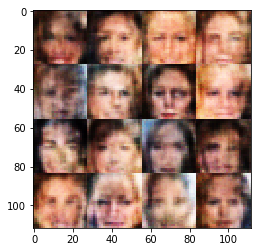

Epoch   1/1   Batch 810 | Loss: Discriminator = 1.12784, Generator = 0.82009
Epoch   1/1   Batch 820 | Loss: Discriminator = 1.24675, Generator = 0.63396
Epoch   1/1   Batch 830 | Loss: Discriminator = 1.11273, Generator = 0.99542
Epoch   1/1   Batch 840 | Loss: Discriminator = 1.14979, Generator = 0.94787
Epoch   1/1   Batch 850 | Loss: Discriminator = 0.77209, Generator = 1.56638
Epoch   1/1   Batch 860 | Loss: Discriminator = 1.18897, Generator = 0.73123
Epoch   1/1   Batch 870 | Loss: Discriminator = 1.15804, Generator = 1.17678
Epoch   1/1   Batch 880 | Loss: Discriminator = 1.24969, Generator = 0.74462
Epoch   1/1   Batch 890 | Loss: Discriminator = 1.67929, Generator = 0.30224
Epoch   1/1   Batch 900 | Loss: Discriminator = 1.20786, Generator = 0.82564


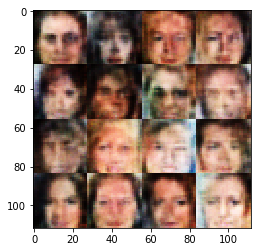

Epoch   1/1   Batch 910 | Loss: Discriminator = 1.10793, Generator = 0.81178
Epoch   1/1   Batch 920 | Loss: Discriminator = 1.12654, Generator = 0.94505
Epoch   1/1   Batch 930 | Loss: Discriminator = 1.06952, Generator = 0.88566
Epoch   1/1   Batch 940 | Loss: Discriminator = 1.12164, Generator = 1.03589
Epoch   1/1   Batch 950 | Loss: Discriminator = 1.09357, Generator = 0.78581
Epoch   1/1   Batch 960 | Loss: Discriminator = 1.18671, Generator = 0.66200
Epoch   1/1   Batch 970 | Loss: Discriminator = 1.16174, Generator = 0.72911
Epoch   1/1   Batch 980 | Loss: Discriminator = 1.22347, Generator = 0.65922
Epoch   1/1   Batch 990 | Loss: Discriminator = 1.02163, Generator = 1.11438
Epoch   1/1   Batch 1000 | Loss: Discriminator = 1.11080, Generator = 0.78099


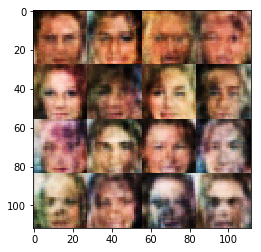

Epoch   1/1   Batch 1010 | Loss: Discriminator = 1.18098, Generator = 0.63734
Epoch   1/1   Batch 1020 | Loss: Discriminator = 1.83782, Generator = 2.06517
Epoch   1/1   Batch 1030 | Loss: Discriminator = 1.03469, Generator = 0.85012
Epoch   1/1   Batch 1040 | Loss: Discriminator = 1.13917, Generator = 0.91083
Epoch   1/1   Batch 1050 | Loss: Discriminator = 1.02078, Generator = 1.22981
Epoch   1/1   Batch 1060 | Loss: Discriminator = 1.15272, Generator = 0.82000
Epoch   1/1   Batch 1070 | Loss: Discriminator = 1.14873, Generator = 0.55728
Epoch   1/1   Batch 1080 | Loss: Discriminator = 1.18834, Generator = 0.76948
Epoch   1/1   Batch 1090 | Loss: Discriminator = 0.90502, Generator = 1.78402
Epoch   1/1   Batch 1100 | Loss: Discriminator = 1.12233, Generator = 0.81336


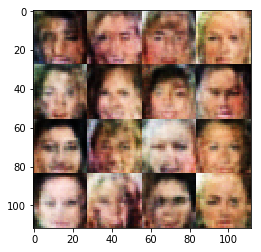

Epoch   1/1   Batch 1110 | Loss: Discriminator = 1.03508, Generator = 0.96369
Epoch   1/1   Batch 1120 | Loss: Discriminator = 1.11523, Generator = 0.91052
Epoch   1/1   Batch 1130 | Loss: Discriminator = 1.10109, Generator = 0.74376
Epoch   1/1   Batch 1140 | Loss: Discriminator = 1.11882, Generator = 0.83013
Epoch   1/1   Batch 1150 | Loss: Discriminator = 1.15689, Generator = 0.81500
Epoch   1/1   Batch 1160 | Loss: Discriminator = 1.13345, Generator = 0.89906
Epoch   1/1   Batch 1170 | Loss: Discriminator = 2.26052, Generator = 0.12959
Epoch   1/1   Batch 1180 | Loss: Discriminator = 1.16818, Generator = 0.78174
Epoch   1/1   Batch 1190 | Loss: Discriminator = 1.13813, Generator = 0.76416
Epoch   1/1   Batch 1200 | Loss: Discriminator = 1.26310, Generator = 0.51744


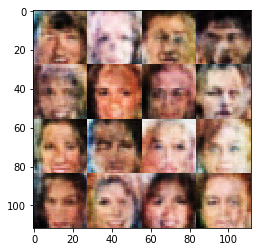

Epoch   1/1   Batch 1210 | Loss: Discriminator = 1.09342, Generator = 0.78466
Epoch   1/1   Batch 1220 | Loss: Discriminator = 1.14234, Generator = 0.77722
Epoch   1/1   Batch 1230 | Loss: Discriminator = 1.12793, Generator = 0.63241
Epoch   1/1   Batch 1240 | Loss: Discriminator = 1.20245, Generator = 0.65418
Epoch   1/1   Batch 1250 | Loss: Discriminator = 0.93880, Generator = 0.79772
Epoch   1/1   Batch 1260 | Loss: Discriminator = 1.13062, Generator = 0.86354
Epoch   1/1   Batch 1270 | Loss: Discriminator = 1.33436, Generator = 0.45779
Epoch   1/1   Batch 1280 | Loss: Discriminator = 1.10497, Generator = 0.60861
Epoch   1/1   Batch 1290 | Loss: Discriminator = 1.15761, Generator = 0.78204
Epoch   1/1   Batch 1300 | Loss: Discriminator = 1.19060, Generator = 0.95663


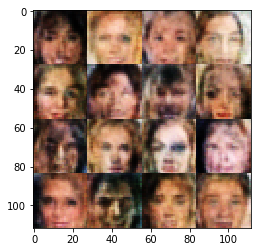

Epoch   1/1   Batch 1310 | Loss: Discriminator = 1.05970, Generator = 0.68160
Epoch   1/1   Batch 1320 | Loss: Discriminator = 1.19652, Generator = 0.59124
Epoch   1/1   Batch 1330 | Loss: Discriminator = 1.04379, Generator = 1.27834
Epoch   1/1   Batch 1340 | Loss: Discriminator = 1.12840, Generator = 0.90880
Epoch   1/1   Batch 1350 | Loss: Discriminator = 1.06313, Generator = 1.11753
Epoch   1/1   Batch 1360 | Loss: Discriminator = 1.12366, Generator = 1.16027
Epoch   1/1   Batch 1370 | Loss: Discriminator = 0.82660, Generator = 1.02052
Epoch   1/1   Batch 1380 | Loss: Discriminator = 1.16814, Generator = 0.76431
Epoch   1/1   Batch 1390 | Loss: Discriminator = 1.09418, Generator = 0.90486
Epoch   1/1   Batch 1400 | Loss: Discriminator = 1.44775, Generator = 0.40841


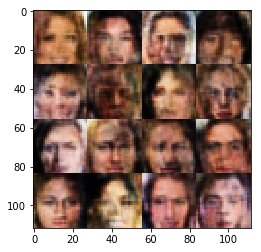

Epoch   1/1   Batch 1410 | Loss: Discriminator = 1.07230, Generator = 0.86237
Epoch   1/1   Batch 1420 | Loss: Discriminator = 1.19860, Generator = 0.59708
Epoch   1/1   Batch 1430 | Loss: Discriminator = 1.09465, Generator = 0.81984
Epoch   1/1   Batch 1440 | Loss: Discriminator = 1.09260, Generator = 1.19359
Epoch   1/1   Batch 1450 | Loss: Discriminator = 1.12546, Generator = 1.24688
Epoch   1/1   Batch 1460 | Loss: Discriminator = 1.07465, Generator = 0.92528
Epoch   1/1   Batch 1470 | Loss: Discriminator = 1.11864, Generator = 1.39497
Epoch   1/1   Batch 1480 | Loss: Discriminator = 1.20016, Generator = 0.65580
Epoch   1/1   Batch 1490 | Loss: Discriminator = 1.19124, Generator = 0.60226
Epoch   1/1   Batch 1500 | Loss: Discriminator = 1.16455, Generator = 0.57804


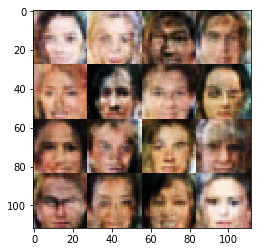

Epoch   1/1   Batch 1510 | Loss: Discriminator = 1.07014, Generator = 1.00977
Epoch   1/1   Batch 1520 | Loss: Discriminator = 1.10570, Generator = 1.15074
Epoch   1/1   Batch 1530 | Loss: Discriminator = 0.82325, Generator = 1.41342
Epoch   1/1   Batch 1540 | Loss: Discriminator = 1.05625, Generator = 0.93617
Epoch   1/1   Batch 1550 | Loss: Discriminator = 1.14904, Generator = 0.88312
Epoch   1/1   Batch 1560 | Loss: Discriminator = 1.34392, Generator = 0.48728
Epoch   1/1   Batch 1570 | Loss: Discriminator = 1.06550, Generator = 0.69080
Epoch   1/1   Batch 1580 | Loss: Discriminator = 1.11566, Generator = 0.63206
Epoch   1/1   Batch 1590 | Loss: Discriminator = 1.14445, Generator = 0.90625
Epoch   1/1   Batch 1600 | Loss: Discriminator = 1.02915, Generator = 0.71447


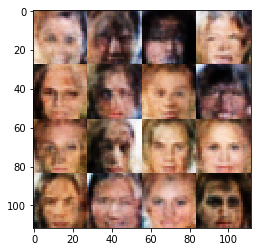

Epoch   1/1   Batch 1610 | Loss: Discriminator = 1.11429, Generator = 0.79235
Epoch   1/1   Batch 1620 | Loss: Discriminator = 1.19735, Generator = 0.63757
Epoch   1/1   Batch 1630 | Loss: Discriminator = 1.20488, Generator = 0.50988
Epoch   1/1   Batch 1640 | Loss: Discriminator = 1.21533, Generator = 0.84706
Epoch   1/1   Batch 1650 | Loss: Discriminator = 1.18391, Generator = 0.63845
Epoch   1/1   Batch 1660 | Loss: Discriminator = 1.13179, Generator = 0.62949
Epoch   1/1   Batch 1670 | Loss: Discriminator = 1.12855, Generator = 0.78570
Epoch   1/1   Batch 1680 | Loss: Discriminator = 1.19205, Generator = 1.17107
Epoch   1/1   Batch 1690 | Loss: Discriminator = 1.39950, Generator = 1.50226
Epoch   1/1   Batch 1700 | Loss: Discriminator = 0.98604, Generator = 0.95979


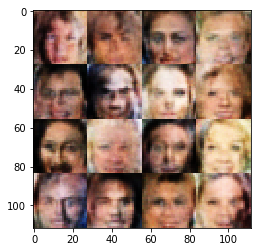

Epoch   1/1   Batch 1710 | Loss: Discriminator = 1.12317, Generator = 0.79646
Epoch   1/1   Batch 1720 | Loss: Discriminator = 1.23803, Generator = 1.42308
Epoch   1/1   Batch 1730 | Loss: Discriminator = 1.12767, Generator = 1.04684
Epoch   1/1   Batch 1740 | Loss: Discriminator = 1.32701, Generator = 1.52159
Epoch   1/1   Batch 1750 | Loss: Discriminator = 1.11590, Generator = 0.89380
Epoch   1/1   Batch 1760 | Loss: Discriminator = 1.32632, Generator = 0.44789
Epoch   1/1   Batch 1770 | Loss: Discriminator = 1.01930, Generator = 1.00846
Epoch   1/1   Batch 1780 | Loss: Discriminator = 1.17626, Generator = 0.67467
Epoch   1/1   Batch 1790 | Loss: Discriminator = 1.25036, Generator = 0.53605
Epoch   1/1   Batch 1800 | Loss: Discriminator = 1.21691, Generator = 0.55429


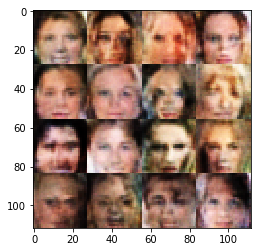

Epoch   1/1   Batch 1810 | Loss: Discriminator = 0.88422, Generator = 1.40662
Epoch   1/1   Batch 1820 | Loss: Discriminator = 1.13595, Generator = 0.79795
Epoch   1/1   Batch 1830 | Loss: Discriminator = 1.10127, Generator = 1.59627
Epoch   1/1   Batch 1840 | Loss: Discriminator = 0.98890, Generator = 0.98822
Epoch   1/1   Batch 1850 | Loss: Discriminator = 1.16453, Generator = 0.76199
Epoch   1/1   Batch 1860 | Loss: Discriminator = 1.47975, Generator = 0.36035
Epoch   1/1   Batch 1870 | Loss: Discriminator = 0.93693, Generator = 1.02782
Epoch   1/1   Batch 1880 | Loss: Discriminator = 1.11546, Generator = 0.97686
Epoch   1/1   Batch 1890 | Loss: Discriminator = 1.00748, Generator = 1.22517
Epoch   1/1   Batch 1900 | Loss: Discriminator = 0.92047, Generator = 0.93971


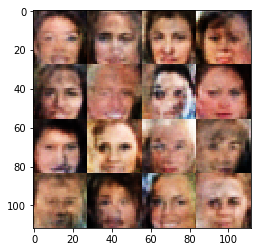

Epoch   1/1   Batch 1910 | Loss: Discriminator = 1.21191, Generator = 0.75085
Epoch   1/1   Batch 1920 | Loss: Discriminator = 1.01940, Generator = 0.70291
Epoch   1/1   Batch 1930 | Loss: Discriminator = 1.16882, Generator = 0.85185
Epoch   1/1   Batch 1940 | Loss: Discriminator = 1.09679, Generator = 0.67741
Epoch   1/1   Batch 1950 | Loss: Discriminator = 1.02820, Generator = 0.89089
Epoch   1/1   Batch 1960 | Loss: Discriminator = 1.19105, Generator = 0.89432
Epoch   1/1   Batch 1970 | Loss: Discriminator = 1.02726, Generator = 1.04990
Epoch   1/1   Batch 1980 | Loss: Discriminator = 1.14813, Generator = 0.73379
Epoch   1/1   Batch 1990 | Loss: Discriminator = 1.45324, Generator = 0.39491
Epoch   1/1   Batch 2000 | Loss: Discriminator = 1.00609, Generator = 0.94464


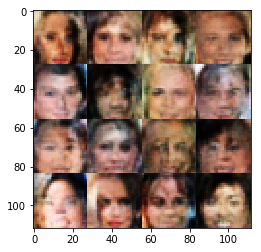

Epoch   1/1   Batch 2010 | Loss: Discriminator = 1.15756, Generator = 0.73751
Epoch   1/1   Batch 2020 | Loss: Discriminator = 0.84608, Generator = 1.59602
Epoch   1/1   Batch 2030 | Loss: Discriminator = 1.06451, Generator = 0.76688
Epoch   1/1   Batch 2040 | Loss: Discriminator = 1.16947, Generator = 0.68720
Epoch   1/1   Batch 2050 | Loss: Discriminator = 1.26115, Generator = 0.52376
Epoch   1/1   Batch 2060 | Loss: Discriminator = 0.98250, Generator = 0.95807
Epoch   1/1   Batch 2070 | Loss: Discriminator = 1.16005, Generator = 0.76162
Epoch   1/1   Batch 2080 | Loss: Discriminator = 0.96532, Generator = 0.84626
Epoch   1/1   Batch 2090 | Loss: Discriminator = 1.21562, Generator = 0.81159
Epoch   1/1   Batch 2100 | Loss: Discriminator = 1.08320, Generator = 0.81793


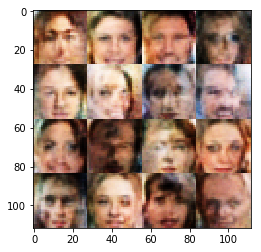

Epoch   1/1   Batch 2110 | Loss: Discriminator = 1.17004, Generator = 0.81139
Epoch   1/1   Batch 2120 | Loss: Discriminator = 1.02772, Generator = 0.86768
Epoch   1/1   Batch 2130 | Loss: Discriminator = 1.19098, Generator = 0.80607
Epoch   1/1   Batch 2140 | Loss: Discriminator = 1.41466, Generator = 1.49620
Epoch   1/1   Batch 2150 | Loss: Discriminator = 1.31027, Generator = 1.28087
Epoch   1/1   Batch 2160 | Loss: Discriminator = 0.93541, Generator = 1.24979
Epoch   1/1   Batch 2170 | Loss: Discriminator = 1.01197, Generator = 1.02844
Epoch   1/1   Batch 2180 | Loss: Discriminator = 1.05821, Generator = 0.94070
Epoch   1/1   Batch 2190 | Loss: Discriminator = 1.91160, Generator = 2.11169
Epoch   1/1   Batch 2200 | Loss: Discriminator = 0.92314, Generator = 1.13742


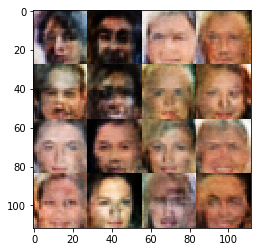

Epoch   1/1   Batch 2210 | Loss: Discriminator = 1.21737, Generator = 0.84119
Epoch   1/1   Batch 2220 | Loss: Discriminator = 1.11617, Generator = 0.90049
Epoch   1/1   Batch 2230 | Loss: Discriminator = 1.22106, Generator = 1.39471
Epoch   1/1   Batch 2240 | Loss: Discriminator = 1.19284, Generator = 1.05782
Epoch   1/1   Batch 2250 | Loss: Discriminator = 0.97157, Generator = 0.76823
Epoch   1/1   Batch 2260 | Loss: Discriminator = 1.12582, Generator = 0.78013
Epoch   1/1   Batch 2270 | Loss: Discriminator = 0.97964, Generator = 1.07053
Epoch   1/1   Batch 2280 | Loss: Discriminator = 1.22133, Generator = 0.68635
Epoch   1/1   Batch 2290 | Loss: Discriminator = 1.23851, Generator = 0.72408
Epoch   1/1   Batch 2300 | Loss: Discriminator = 1.01814, Generator = 0.94571


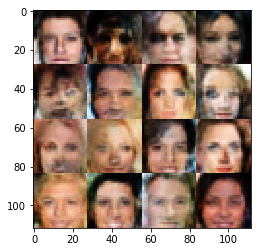

Epoch   1/1   Batch 2310 | Loss: Discriminator = 1.08702, Generator = 1.06696
Epoch   1/1   Batch 2320 | Loss: Discriminator = 1.15235, Generator = 0.78086
Epoch   1/1   Batch 2330 | Loss: Discriminator = 1.43573, Generator = 1.68300
Epoch   1/1   Batch 2340 | Loss: Discriminator = 0.93567, Generator = 1.01831
Epoch   1/1   Batch 2350 | Loss: Discriminator = 1.15175, Generator = 0.99510
Epoch   1/1   Batch 2360 | Loss: Discriminator = 1.42446, Generator = 1.33911
Epoch   1/1   Batch 2370 | Loss: Discriminator = 1.20586, Generator = 0.65495
Epoch   1/1   Batch 2380 | Loss: Discriminator = 1.11767, Generator = 0.77355
Epoch   1/1   Batch 2390 | Loss: Discriminator = 1.23758, Generator = 1.45271
Epoch   1/1   Batch 2400 | Loss: Discriminator = 0.87769, Generator = 1.00562


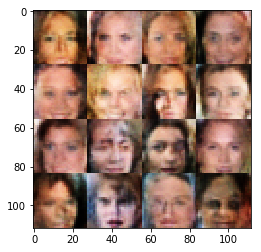

Epoch   1/1   Batch 2410 | Loss: Discriminator = 1.12038, Generator = 0.77173
Epoch   1/1   Batch 2420 | Loss: Discriminator = 1.02385, Generator = 0.91632
Epoch   1/1   Batch 2430 | Loss: Discriminator = 1.29598, Generator = 0.50839
Epoch   1/1   Batch 2440 | Loss: Discriminator = 0.94079, Generator = 1.07678
Epoch   1/1   Batch 2450 | Loss: Discriminator = 1.11487, Generator = 1.25622
Epoch   1/1   Batch 2460 | Loss: Discriminator = 1.11186, Generator = 0.65866
Epoch   1/1   Batch 2470 | Loss: Discriminator = 1.08758, Generator = 0.73102
Epoch   1/1   Batch 2480 | Loss: Discriminator = 1.14749, Generator = 0.63195
Epoch   1/1   Batch 2490 | Loss: Discriminator = 1.43400, Generator = 0.43644
Epoch   1/1   Batch 2500 | Loss: Discriminator = 1.06983, Generator = 0.72629


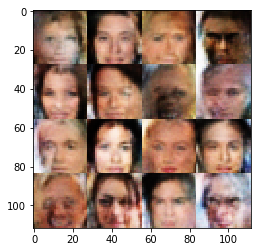

Epoch   1/1   Batch 2510 | Loss: Discriminator = 1.13797, Generator = 0.74815
Epoch   1/1   Batch 2520 | Loss: Discriminator = 1.23337, Generator = 0.60597
Epoch   1/1   Batch 2530 | Loss: Discriminator = 1.10096, Generator = 0.77551
Epoch   1/1   Batch 2540 | Loss: Discriminator = 1.15669, Generator = 0.80056
Epoch   1/1   Batch 2550 | Loss: Discriminator = 1.13771, Generator = 0.58546
Epoch   1/1   Batch 2560 | Loss: Discriminator = 0.92268, Generator = 1.24945
Epoch   1/1   Batch 2570 | Loss: Discriminator = 1.16614, Generator = 1.01155
Epoch   1/1   Batch 2580 | Loss: Discriminator = 1.23880, Generator = 0.56173
Epoch   1/1   Batch 2590 | Loss: Discriminator = 1.72171, Generator = 0.25461
Epoch   1/1   Batch 2600 | Loss: Discriminator = 1.21554, Generator = 0.67541


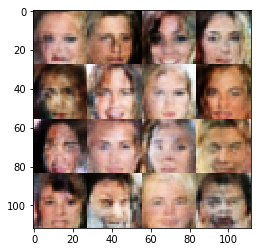

Epoch   1/1   Batch 2610 | Loss: Discriminator = 1.05736, Generator = 0.57950
Epoch   1/1   Batch 2620 | Loss: Discriminator = 1.15193, Generator = 0.60849
Epoch   1/1   Batch 2630 | Loss: Discriminator = 0.79310, Generator = 0.94063
Epoch   1/1   Batch 2640 | Loss: Discriminator = 1.02425, Generator = 1.07932
Epoch   1/1   Batch 2650 | Loss: Discriminator = 1.57135, Generator = 1.56245
Epoch   1/1   Batch 2660 | Loss: Discriminator = 0.97236, Generator = 1.02538
Epoch   1/1   Batch 2670 | Loss: Discriminator = 1.21957, Generator = 0.75202
Epoch   1/1   Batch 2680 | Loss: Discriminator = 0.94826, Generator = 0.83616
Epoch   1/1   Batch 2690 | Loss: Discriminator = 1.21746, Generator = 0.66932
Epoch   1/1   Batch 2700 | Loss: Discriminator = 1.13922, Generator = 1.20363


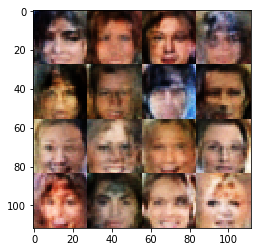

Epoch   1/1   Batch 2710 | Loss: Discriminator = 1.00396, Generator = 1.20208
Epoch   1/1   Batch 2720 | Loss: Discriminator = 1.16998, Generator = 1.06866
Epoch   1/1   Batch 2730 | Loss: Discriminator = 1.18079, Generator = 0.76628
Epoch   1/1   Batch 2740 | Loss: Discriminator = 1.14936, Generator = 0.85712
Epoch   1/1   Batch 2750 | Loss: Discriminator = 1.07193, Generator = 1.03406
Epoch   1/1   Batch 2760 | Loss: Discriminator = 0.95320, Generator = 1.10798
Epoch   1/1   Batch 2770 | Loss: Discriminator = 1.14217, Generator = 0.88452
Epoch   1/1   Batch 2780 | Loss: Discriminator = 1.03744, Generator = 1.31128
Epoch   1/1   Batch 2790 | Loss: Discriminator = 0.99024, Generator = 1.18981
Epoch   1/1   Batch 2800 | Loss: Discriminator = 1.42614, Generator = 0.39171


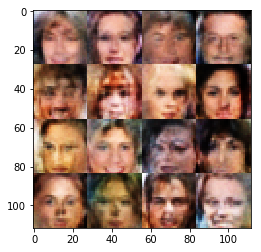

Epoch   1/1   Batch 2810 | Loss: Discriminator = 1.28255, Generator = 0.49724
Epoch   1/1   Batch 2820 | Loss: Discriminator = 1.21430, Generator = 0.52418
Epoch   1/1   Batch 2830 | Loss: Discriminator = 1.16354, Generator = 0.70226
Epoch   1/1   Batch 2840 | Loss: Discriminator = 1.28422, Generator = 0.50686
Epoch   1/1   Batch 2850 | Loss: Discriminator = 0.87465, Generator = 0.91666
Epoch   1/1   Batch 2860 | Loss: Discriminator = 1.04749, Generator = 0.77259
Epoch   1/1   Batch 2870 | Loss: Discriminator = 1.03781, Generator = 1.13417
Epoch   1/1   Batch 2880 | Loss: Discriminator = 0.99721, Generator = 0.97918
Epoch   1/1   Batch 2890 | Loss: Discriminator = 1.15860, Generator = 1.29269
Epoch   1/1   Batch 2900 | Loss: Discriminator = 0.92413, Generator = 1.46077


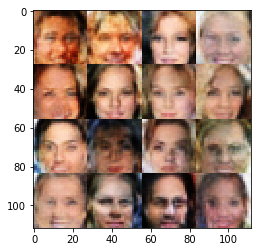

Epoch   1/1   Batch 2910 | Loss: Discriminator = 1.01576, Generator = 1.15432
Epoch   1/1   Batch 2920 | Loss: Discriminator = 1.09400, Generator = 0.93293
Epoch   1/1   Batch 2930 | Loss: Discriminator = 0.98800, Generator = 1.35823
Epoch   1/1   Batch 2940 | Loss: Discriminator = 1.15084, Generator = 0.77492
Epoch   1/1   Batch 2950 | Loss: Discriminator = 1.30967, Generator = 0.60572
Epoch   1/1   Batch 2960 | Loss: Discriminator = 0.93603, Generator = 1.06602
Epoch   1/1   Batch 2970 | Loss: Discriminator = 1.03374, Generator = 1.01569
Epoch   1/1   Batch 2980 | Loss: Discriminator = 1.14361, Generator = 0.70129
Epoch   1/1   Batch 2990 | Loss: Discriminator = 1.24730, Generator = 1.63206
Epoch   1/1   Batch 3000 | Loss: Discriminator = 1.19084, Generator = 0.60896


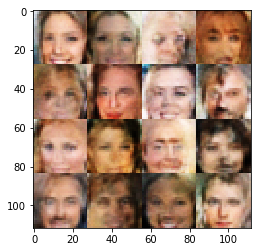

Epoch   1/1   Batch 3010 | Loss: Discriminator = 1.13732, Generator = 1.05991
Epoch   1/1   Batch 3020 | Loss: Discriminator = 1.05263, Generator = 0.76849
Epoch   1/1   Batch 3030 | Loss: Discriminator = 1.12046, Generator = 0.76292
Epoch   1/1   Batch 3040 | Loss: Discriminator = 1.22930, Generator = 1.16150
Epoch   1/1   Batch 3050 | Loss: Discriminator = 1.10860, Generator = 0.75007
Epoch   1/1   Batch 3060 | Loss: Discriminator = 0.92370, Generator = 1.00312
Epoch   1/1   Batch 3070 | Loss: Discriminator = 1.19409, Generator = 0.67195
Epoch   1/1   Batch 3080 | Loss: Discriminator = 1.12315, Generator = 0.76047
Epoch   1/1   Batch 3090 | Loss: Discriminator = 1.04409, Generator = 1.03605
Epoch   1/1   Batch 3100 | Loss: Discriminator = 1.09946, Generator = 0.98790


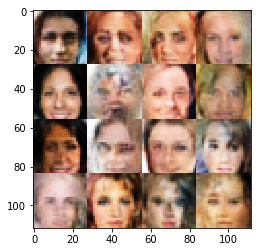

Epoch   1/1   Batch 3110 | Loss: Discriminator = 1.24891, Generator = 0.51447
Epoch   1/1   Batch 3120 | Loss: Discriminator = 1.29064, Generator = 0.46159
Epoch   1/1   Batch 3130 | Loss: Discriminator = 0.80250, Generator = 0.82469
Epoch   1/1   Batch 3140 | Loss: Discriminator = 1.01233, Generator = 0.92878
Epoch   1/1   Batch 3150 | Loss: Discriminator = 1.39623, Generator = 0.48690
Epoch   1/1   Batch 3160 | Loss: Discriminator = 0.77492, Generator = 0.85390


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.